In [2]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import beta as betadist
from scipy.stats import norm
from scipy.special import beta, betainc
from scipy.integrate import quad as integrate
from scipy.integrate import dblquad
from numpy import sqrt
from numpy import vectorize as Vectorize
from math import asin
from numba import jit, njit
import time
import pickle
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 20})
np.set_printoptions(linewidth=100)

# Generate simulation data

In [15]:
@jit(nopython=True)
def generate_data(I = 50, k = random.uniform(0, 8), csig=1., rlsig=1.):
    Xi = []
    Yi = []
    ci = []
    ri = []
#     random.seed(seed)
    for i in range(I):
        ci.append(random.gauss(0,csig))
        ri.append(random.lognormvariate(0,rlsig))
        li = ci[-1] - ri[-1]
        mi = ci[-1] + ri[-1]
        Xi.append([li, mi])
        Yi.append([li + k, mi + k])
    ci_dash = [e + k for e in ci]
    return Xi, Yi, ci, ri, ci_dash, k              

In [35]:
# %%timeit
Xi, Yi, c1, r1, c2, k = generate_data(I=1000, k=3.7, csig=0.5)
r2 = r1

ci_joined = c1 + c2
ri_joined = r1 + r2 

In [85]:
# no jit
%%timeit
Xi, Yi, c1, r1, c2, k = generate_data(I=20, k=1.1)
r2 = r1

ci_joined = c1 + c2
ri_joined = r1 + r2 

UsageError: Line magic function `%%timeit` not found.


In [323]:
# jit()
%%timeit
Xi, Yi, c1, r1, c2, k = generate_data(I=20, k=2)
r2 = r1

ci_joined = c1 + c2
ri_joined = r1 + r2 

UsageError: Line magic function `%%timeit` not found.


In [481]:
# K = [np.linspace(0.0465,0.93,20), np.linspace(0.155,4.65,30), np.linspace(0.2325,9.3,40)]
# for csig,K in zip([0.1, 0.5, 1.],K):
#     print(K.shape)
#     for rlsig in [0.1, 0.5, 1.]:
#         if (csig!=1. or rlsig!=1.):
#             print(f'csig: {csig} rlsig: {rlsig}')

scenarios = ['XunifYunif', 'XunifYsym', 'XsymYsym']
methods = [1,2]
for scenario in scenarios[1:]:
    for method in methods:
        print(scenario, method)

XunifYsym 1
XunifYsym 2
XsymYsym 1
XsymYsym 2


In [477]:
start=time.time()

In [480]:
end=time.time()
(end-start)/60.

5.509273119767507

In [356]:
round(2.5*norm.ppf(0.9999, scale=0.1),2), round(2.5*norm.ppf(0.9999, scale=0.5),2), round(2.5*norm.ppf(0.9999),2)

(0.93, 4.65, 9.3)

(array([  6.,  25.,  61., 144., 232., 236., 191.,  72.,  26.,   7.]),
 array([-1.62579284, -1.31134738, -0.99690193, -0.68245647, -0.36801101, -0.05356555,  0.26087991,
         0.57532537,  0.88977083,  1.20421629,  1.51866175]),
 <a list of 10 Patch objects>)

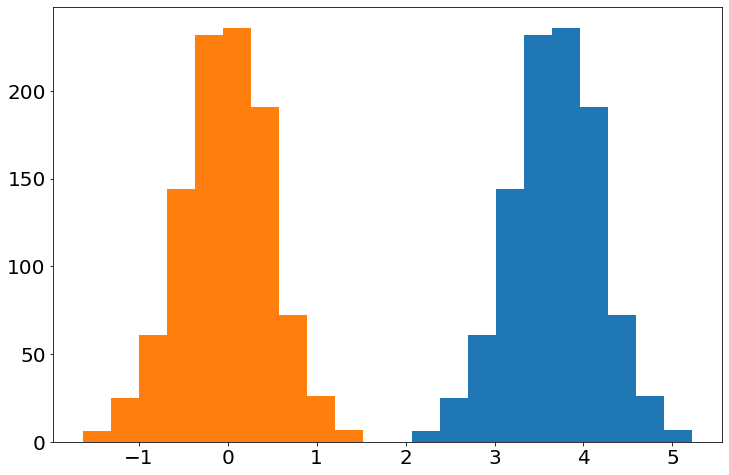

In [36]:
plt.hist(c2) 
plt.hist(c1)

(array([8.417e+03, 1.175e+03, 2.500e+02, 8.000e+01, 3.600e+01, 2.000e+01, 1.400e+01, 5.000e+00,
        2.000e+00, 1.000e+00]),
 array([2.14827004e-02, 2.81913451e+00, 5.61678632e+00, 8.41443813e+00, 1.12120899e+01,
        1.40097418e+01, 1.68073936e+01, 1.96050454e+01, 2.24026972e+01, 2.52003490e+01,
        2.79980008e+01]),
 <a list of 10 Patch objects>)

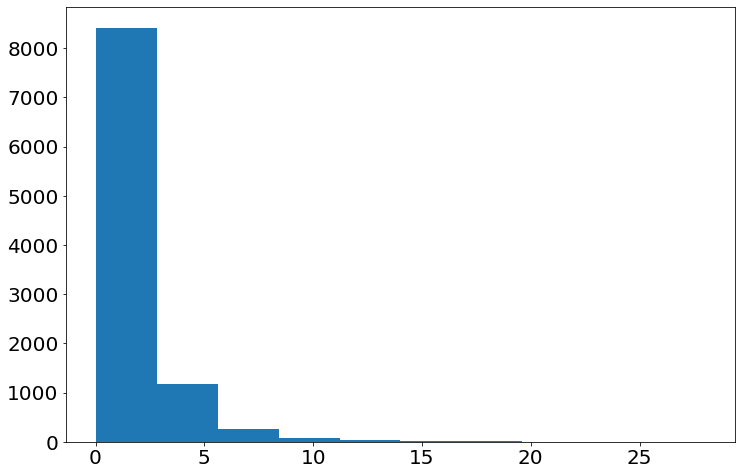

In [10]:
plt.hist(r1)

In [373]:
np.linspace(0,9.3,41)

array([0.    , 0.2325, 0.465 , 0.6975, 0.93  , 1.1625, 1.395 , 1.6275, 1.86  , 2.0925, 2.325 ,
       2.5575, 2.79  , 3.0225, 3.255 , 3.4875, 3.72  , 3.9525, 4.185 , 4.4175, 4.65  , 4.8825,
       5.115 , 5.3475, 5.58  , 5.8125, 6.045 , 6.2775, 6.51  , 6.7425, 6.975 , 7.2075, 7.44  ,
       7.6725, 7.905 , 8.1375, 8.37  , 8.6025, 8.835 , 9.0675, 9.3   ])

## Quantile Functions and Mallows Distances

In [16]:
# write our own beta distribution function 
@jit(nopython=True)
def BetaPDF(t,a,b):
    if t<0 or t>1:
        return 0.
    else:
        return 1/beta(a,b)*t**(a-1)*(1-t)**(b-1)

In [17]:
@jit(nopython=True)
def QUnif(t, c, r):
    assert (t>0 and t<1), "t must be in [0,1]"
    return (c-r + 2*t*r)

In [18]:
@jit(nopython=True)
def QTri(t, c, r, m):
    assert (t>0 and t<1), "t must be in [0,1]"
    assert (m>c-r and m<c+r), "m must be in [c-r,c+r]"
    thresh = (m-c+r)/(2*r)
    if (t <= thresh):
        Q = c-r + sqrt(2*r*(m-c+r)*t)
    else:
        Q = c+r - sqrt(2*r*(c+r-m)*(1-t))
    return Q

# Mean quantile function
@jit(nopython=True)
def mQTri(t,c,r,a,b):
    assert (a>=0 and b>=0), "a and b must be positive"
    if (a==1 and b==1):
        part1 = 2*r*t+c-r
        part2 = 4/3.*r*(sqrt(t) - sqrt(1-t) - t**2 + (1-t)**2)
    else:
        part1 = 2*r * BetaPDF(t,a,b) + c - r
        part2 = 2*r / beta(a,b) * ( sqrt(t) * ( beta(a+1/2,b) - betainc(a+1/2,b,t)  ) - sqrt(1-t) * betainc(a,b+1/2,t) )
    return part1 + part2    

In [19]:
#
#
# Mallows distances
#
#

# Assume the 1st interval is given by [c1-r1, c1+r1]
# Assume the 2nd interval is given by [c2-r2, c2+r2]


##
## Assume the data are uniformly distributed over the 1st interval
## Assume the data are uniformly distributed over the 2nd interval
##
@jit(nopython=True)
def MalUnifUnif(c1,r1,c2,r2):
    return sqrt((c1 - c2)**2 + 1./3*(r1-r2)**2)

##
## Assume the data are uniformly distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
@jit(nopython=True)
def MalUnifTri(c1,r1,c2,r2,m2):
    assert (m2>(c2-r2) and m2<(c2+r2)), "Mode m2 must be within [c2-r2,c2+r2]"
    val1 = c1-c2-r1+r2
    val2 = c1-c2-r1-r2
    pt1 = 4/3.*r1**2 + 2 * val2*r1 + val1**2 / (2*r2) * (m2-c2+r2)
    pt2 = val2**2 / (2*r2) * (c2-m2+r2)
    pt3 = (m2-c2+r2)**2 * (r1 - 2/3.*val1)/r2
    pt4 = (c2-m2+r2)**2 * (4/3.*r1 + 2/3.*val2)/r2
    pt5 = (1/(4*r2) -2*r1/(5*r2**2)) * ( (m2-c2+r2)**3 + (c2-m2+r2)**3 )
    return sqrt(pt1 + pt2 + pt3 + pt4 + pt5)

##
## Assume the data are triangular distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
@jit(nopython=True)
def MalTriTri(c1,r1,m1,c2,r2,m2):
    assert (m1>(c1-r1) and m1<(c1+r1)), "Mode m1 must be within [c1-r1,c1+r1]"
    assert (m2>(c2-r2) and m2<(c2+r2)), "Mode m2 must be within [c2-r2,c2+r2]"
    Index = ( (m1-c1)/r1 <= (m2-c2)/r2 )
  
    part0 = (c1-c2)**2 + 1/6.*((r1-r2)**2 + (m1-c1)**2 + (m2-c2)**2) - 5/3.*r1*r2
    if (Index):
        pt1A = c1-c2+r2
        pt1B = c1-c2+r1
        pt2 = (5 - (m1-c1)/r1)
        pt3 = (5 + (m2-c2)/r2)
        part4 = sqrt(r1*r2*(c1-m1+r1)*(m2-c2+r2))/2*(asin((m2-c2)/r2) - asin((m1-c1)/r1))
    else:
        pt1A = c1-c2-r2
        pt1B = c1-c2-r1    
        pt2 = (5 - (m2-c2)/r2)
        pt3 = (5 + (m1-c1)/r1)
        part4 = sqrt(r1*r2*(c2-m2+r2)*(m1-c1+r1))/2*(asin((m1-c1)/r1) - asin((m2-c2)/r2))
        
    part1 = 2*(m1-c1)*pt1A/3 - 2*(m2-c2)*pt1B/3
    part2 = sqrt(r1*r2*(m1-c1+r1)*(m2-c2+r2))/6 * pt2
    part3 = sqrt(r1*r2*(c1-m1+r1)*(c2-m2+r2))/6 * pt3
    return sqrt(part0 + part1 + part2 + part3 + part4)

### Monte Carlo approach

(array([350., 235., 163., 110.,  62.,  37.,  28.,   9.,   5.,   1.]),
 array([8.43498577e-05, 8.05256504e-02, 1.60966951e-01, 2.41408252e-01, 3.21849552e-01,
        4.02290853e-01, 4.82732153e-01, 5.63173454e-01, 6.43614754e-01, 7.24056055e-01,
        8.04497355e-01]),
 <a list of 10 Patch objects>)

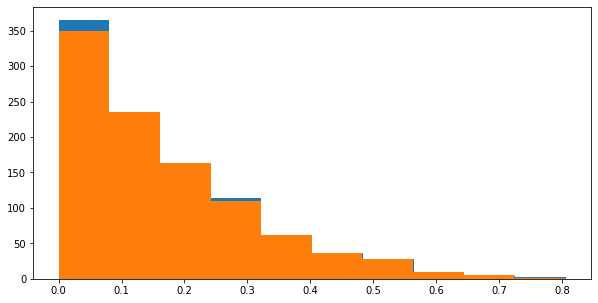

In [30]:
# create a random variate function based on the Beta dist and compare it to scipy.stats.beta.rvs()
t = np.linspace(0, 1, 1000)
p = [BetaPDF(i, 1., 5.) for i in t]
p = p/np.sum(p)
rvs1 = np.random.choice(t, p=p, size=1000)
rvs2 = betadist.rvs(1.,5.,size=1000)
plt.hist(rvs1)
plt.hist(rvs2)

In [9]:
# beta random variate function
@jit
def BetaRVS(a,b,size):
    t = np.linspace(0, 1, 1001)
    p = [BetaPDF(i, a, b) for i in t]
    sump = np.sum(p)
    p = [p/sump for p in p]
    return np.random.choice(t, p=p, size=size) 

In [97]:
BetaRVS(1.,5.,10)

<ipython-input-96-e033189a422a>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "BetaRVS" failed type inference due to: No implementation of function Function(<function sum at 0x2b5e3d8b12f0>) found for signature:
 
 >>> sum(list(float64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'sum': File: numba/core/typing/npydecl.py: Line 348.
        With argument(s): '(list(float64)<iv=None>)':
       No match.

During: resolving callee type: Function(<function sum at 0x2b5e3d8b12f0>)
During: typing of call at <ipython-input-96-e033189a422a> (6)


File "<ipython-input-96-e033189a422a>", line 6:
def BetaRVS(a,b,size):
    <source elided>
    p = [BetaPDF(i, a, b) for i in t]
    sump = np.sum(p)
    ^

  @jit
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "BetaRVS" was co

array([0.272, 0.34 , 0.096, 0.298, 0.018, 0.367, 0.313, 0.02 , 0.048, 0.439])

In [13]:
# Sample m1 and m2 from quantiles of beta distribution and calculate mean over these values
@jit(parallel=True)
def MCMalUnifTri(c1,r1,c2,r2,a2,b2):
    m2 = BetaRVS(a2, b2, size=101)
    d = [MalUnifTri(c1,r1,c2,r2,m2[i]) for i in range(len(m2))]
    return np.mean(d)

@jit(parallel=True)
def MCMalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    m1 = BetaRVS(a1, b1, size=101)
    m2 = BetaRVS(a2, b2, size=101)
    d = [MalTriTri(c1,r1,i,c2,r2,j) for i in m1 for j in m2]
    return np.mean(d)

In [106]:
# with jit
%timeit MCMalUnifTri(c1[0],r1[0],c2[0],r2[0],1.,5.)

<ipython-input-105-74f69eff3eb2>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MCMalUnifTri" failed type inference due to: Invalid use of type(CPUDispatcher(<function BetaRVS at 0x2b5e5302ae18>)) with parameters (float64, float64, size=Literal[int](101))

During: resolving callee type: type(CPUDispatcher(<function BetaRVS at 0x2b5e5302ae18>))
During: typing of call at <ipython-input-105-74f69eff3eb2> (4)


File "<ipython-input-105-74f69eff3eb2>", line 4:
def MCMalUnifTri(c1,r1,c2,r2,a2,b2):
    m2 = BetaRVS(a2, b2, size=101)
    ^

  @jit(parallel=True)


1.47 ms ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "MCMalUnifTri" was compiled in object mode without forceobj=True.

File "<ipython-input-105-74f69eff3eb2>", line 3:
@jit(parallel=True)
def MCMalUnifTri(c1,r1,c2,r2,a2,b2):
^

  state.func_ir.loc))
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-105-74f69eff3eb2>", line 3:
@jit(parallel=True)
def MCMalUnifTri(c1,r1,c2,r2,a2,b2):
^

  state.func_ir.loc))


In [107]:
# with jit
%timeit MCMalTriTri(c1[0],r1[0],1.,5.,c2[0],r2[0],1.,5.)

<ipython-input-105-74f69eff3eb2>:8: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MCMalTriTri" failed type inference due to: Invalid use of type(CPUDispatcher(<function BetaRVS at 0x2b5e5302ae18>)) with parameters (float64, float64, size=Literal[int](101))

During: resolving callee type: type(CPUDispatcher(<function BetaRVS at 0x2b5e5302ae18>))
During: typing of call at <ipython-input-105-74f69eff3eb2> (10)


File "<ipython-input-105-74f69eff3eb2>", line 10:
def MCMalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    m1 = BetaRVS(a1, b1, size=101)
    ^

  @jit(parallel=True)


12.3 ms ± 65 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "MCMalTriTri" was compiled in object mode without forceobj=True.

File "<ipython-input-105-74f69eff3eb2>", line 9:
@jit(parallel=True)
def MCMalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
^

  state.func_ir.loc))
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-105-74f69eff3eb2>", line 9:
@jit(parallel=True)
def MCMalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
^

  state.func_ir.loc))


In [20]:
#
#
# Mean Mallows distances
#
#

# Assume the 1st interval is given by [c1-r1, c1+r1]
# Assume the 2nd interval is given by [c2-r2, c2+r2]
#
# Method 1: compute the Mallows distance using mean quantile functions
# Method 2: compute the mean of the Mallows distances

##
## Assume the data are uniformly distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
## We consider (m2-c2+r2)/(2*r2) to be beta distributed with parameters a2 and b2
## If a2=b2=1 then the mode is uniformly distributed on [c2-r2, c2+r2]

def M2MalUnifTriIntegrand(c1, r1, c2, r2, a2, b2):
    return lambda m2: MalUnifTri(c1, r1, c2, r2, m2)**2 * BetaPDF((m2-c2+r2)/(2*r2), a2, b2) / (2*r2)

def M1MalUnifTriIntegrand(c1, r1, c2, r2, a2, b2):
    return lambda t: (QUnif(t, c1, r1) - mQTri(t, c2, r2, a2, b2) )**2


def M1MalUnifTri(c1,r1,c2,r2,a2,b2):
    assert (a2>=0 and b2>=0), "a and b must be positive"
    
    if (a2==1 and b2==1):
        return sqrt((c1-c2)**2 - 22/45.*r1*r2 +1/3.*r1**2 - (20*math.pi -71)/45.*r2**2)
    else:
        return sqrt(integrate(M1MalUnifTriIntegrand(c1, r1, c2, r2, a2, b2), 0, 1)[0])

def M2MalUnifTri(c1,r1,c2,r2,a2,b2):
    assert (a2>=0 and b2>=0), "a and b must be positive"
    
    if (a2==1 and b2==1):
        return sqrt((c1-c2)**2 - 22*r1*r2/45 +r1**2/3 + 2*r2**2/9)
    else:
        return sqrt(integrate(M2MalUnifTriIntegrand(c1, r1, c2, r2, a2, b2), c2-r2, c2+r2)[0])
    
##
## Assume the data are triangular distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
## We consider (m1-c1+r1)/(2*r1) to be beta distributed with parameters a1 and b1
## If a1=b1=1 then the mode is uniformly distributed on [c1-r1, c1+r1]
## We consider (m2-c2+r2)/(2*r2) to be beta distributed with parameters a2 and b2
## If a2=b2=1 then the mode is uniformly distributed on [c2-r2, c2+r2]

def M1MalTriTriIntegrand(c1,r1,a1,b1,c2,r2,a2,b2):
    return lambda t: (mQTri(t, c1, r1, a1, b1) - mQTri(t, c2, r2, a2, b2) )**2

def M1MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    assert (a1>=0 and b1>=0), "a and b must be positive"
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a1==1 and b1==1 and a2==1 and b2==1):
        return sqrt( (c1-c2)**2 - (20*math.pi-71)/45.*(r2-r1)**2 )
    else:
        return sqrt(integrate(M1MalTriTriIntegrand(c1,r1,a1,b1,c2,r2,a2,b2), 0, 1)[0])
  
def M2MalTriTriDblIntegrand(c1,r1,a1,b1,c2,r2,a2,b2):
    return lambda m1, m2: MalTriTri(c1, r1, m1, c2, r2, m2)**2 * BetaPDF((m1-c1+r1)/(2*r1), a1, b1) / (2*r1) * BetaPDF((m2-c2+r2)/(2*r2), a2, b2) / (2*r2)

def M2MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    assert (a1>=0 and b1>=0), "a and b must be positive"
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a1==1 and b1==1 and a2==1 and b2==1):
        return sqrt( (c1-c2)**2 + 2*(r1**2+r2**2)/9 + (8*math.pi/9 - 142/45)*r1*r2 )
    else:
        return sqrt( dblquad(M2MalTriTriDblIntegrand(c1,r1,a1,b1,c2,r2,a2,b2) , c2-r2, c2+r2, c1-r1, c1+r1 )[0] )
    

### Timing mean mallows distance functions

In [143]:
BetaPDF(0.5,1.,5.)

0.3125

In [61]:
%timeit MalUnifUnif(c1[50],r1[50],c2[50],r2[50])

1.04 µs ± 18.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [63]:
# with jit
%timeit MalUnifUnif(c1[50],r1[50],c2[50],r2[50])

324 ns ± 0.449 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [70]:
# without jit
m = betadist.rvs(1,5,1)
%timeit MalUnifTri(c1[50],r1[50],c2[50],r2[50],m)

6.7 µs ± 7.33 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [68]:
# with jit
m = betadist.rvs(1,5,1)
%timeit MalUnifTri(c1[50],r1[50],c2[50],r2[50],m)

406 ns ± 0.109 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [72]:
# without jit
m1 = betadist.rvs(1,5,1)
m2 = betadist.rvs(1,5,1)
%timeit MalTriTri(c1[50],r1[50],m1,c2[50],r2[50],m2)

15 µs ± 28.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [75]:
# with jit
m1 = betadist.rvs(1,5,1)
m2 = betadist.rvs(1,5,1)
%timeit MalTriTri(c1[50],r1[50],m1,c2[50],r2[50],m2)

534 ns ± 0.133 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
# with jit
%timeit MCMalUnifTri(c1[0],r1[0],c2[0],r2[0],1,5)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'betadist':[0m [1m[1mCannot determine Numba type of <class 'scipy.stats._continuous_distns.beta_gen'>[0m
[1m
File "<ipython-input-21-9e0c0e6ee4a4>", line 4:[0m
[1mdef MCMalUnifTri(c1,r1,c2,r2,a2,b2):
[1m    m2 = betadist.rvs(a2, b2, size=101)
[0m    [1m^[0m[0m
[0m

In [14]:
%timeit MCMalUnifTri(c1[0],r1[0],c2[0],r2[0],1,5)

803 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [154]:
# without jit
%timeit M1MalUnifTri(c1[50],r1[50],c2[50],r2[50],1.,5.) 

5.17 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [144]:
# with jit
%timeit M1MalUnifTri(c1[50],r1[50],c2[50],r2[50],1.,5.) 

493 µs ± 334 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [155]:
# without jit
%timeit M2MalUnifTri(c1[0],r1[0],c2[0],r2[0],1.,5.)

133 µs ± 474 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [145]:
# with jit
%timeit M2MalUnifTri(c1[0],r1[0],c2[0],r2[0],1.,5.)

25 µs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
%%time 
for i in range(100):
    for j in range(100):
#         if j > i:
#         MalUnifUnif(c1[i],r1[i],c1[j],r1[j])
        M2MalUnifTri(c1[i],r1[i],c2[j],r2[j],1,5)

# for i in range(100):
#     for j in range(i+1, 100):
#         MalUnifUnif(c1[i],r1[i],c1[j],r1[j])

CPU times: user 26.2 s, sys: 8.96 ms, total: 26.2 s
Wall time: 26.3 s


In [53]:
%%timeit
for i in range(100):
#     for j in range(i+1,100):
     MCMalTriTri(c1[i],r1[i],1,5,c1[50],r1[50],1,5) 

15.8 s ± 76.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%%timeit
for i in range(100):
#     for j in range(i+1,100):
     M1MalTriTri(c1[i],r1[i],1,5,c1[50],r1[50],1,5) 

10.5 s ± 9.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
# with jit
%timeit M1MalTriTri(c1[0],r1[0],1.,5.,c1[50],r1[50],1.,5.)

613 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [42]:
# without jit
%timeit M1MalTriTri(c1[0],r1[0],1,5,c1[50],r1[50],1,5)

106 ms ± 58 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [170]:
# without jit
%timeit M1MalTriTri(c1[0],r1[0],1.,5.,c2[0],r2[0],1.,5.)

456 µs ± 378 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [164]:
# with jit
%timeit M1MalTriTri(c1[0],r1[0],1.,5.,c2[0],r2[0],1.,5.)

46.2 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
# without jit with nested integrate and vectorize
%timeit M2MalTriTri(c1[0],r1[0],1,5,c2[0],r2[0],1,5)

608 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
# with only BetaPDF and MalTriTri jitted
%timeit M2MalTriTri(c1[0],r1[0],1.,5.,c2[0],r2[0],1.,5.)

11.3 ms ± 78.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
# without jit
%timeit M2MalTriTri(c1[0],r1[0],1.,5.,c2[50],r2[50],1.,5.)

41.1 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
# Dbl integral with only BetaPDF and MalTriTri jitted
%timeit M2MalTriTriDblInt(c1[50],r1[50],1.,5.,c2[50],r2[50],1.,5.)

703 µs ± 674 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
np.allclose([M2MalTriTriDblInt(c1[i],r1[i],1.,5.,c2[90],r2[90],1.,5.) for i in range(100)], [M2MalTriTri(c1[i],r1[i],1.,5.,c2[90],r2[90],1.,5.) for i in range(100)])


True

In [55]:
# Dbl integral with jit
%timeit M2MalTriTriDblInt(c1[50],r1[50],1.,5.,c2[50],r2[50],1.,5.)

702 µs ± 353 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [118]:
a1, a2, b1, b2 = 1,2,10,20

In [21]:
# @jit(parallel=True)
def MallowsDistMatrix(c1, r1, c2, r2, scenario="XunifYunif", method=1, a1=1., b1=1., a2=1., b2=1.):
    """
    ci: the centres of the intervals. A concatenation of ci centres of X intervals and ci_dash intervals of Y intervals.
    ri: ranges of the intervals. A concatenation of ri ranges of X intervals and ri_dash ranges of Y intervals.
    scenario: One of "XunifYunif": both X and Y intervals are uniformly distributed.
               "XunifYsym" : X uniform, Y symmetric.
               "XsymYsym"  : both X and Y intervals are symmetric.
               "Xunifskew" : X uniform, Y skewed (mode follow skewed beta based on a2, b2)
               "Xskewskew" : X skewed (mode follows skewed beta based on a1, b1), Y skewed (mode follow skewed beta based on a2, b2)
    method: 1 or 2. Only applicable to scenarios containing symmetic/skewed distributions (estimated using triangular distributions with modes m~beta(a,b))
                1: Calculate single mallows distance based on mean triangular distribution quantile function
                2: Mean of mallows distances based on varying triangular quantile function
    a1, b1, a2, b2: float parameters of beta distributions
    """
    allowed_scenarios = ['XunifYunif', 'XunifYsym', 'XsymYsym', 'XunifYskew', 'XsymYskew', 'XskewYskew']
    assert scenario in allowed_scenarios, "scenario must be one of 'XunifYunif', 'XunifYsym', or 'XsymYsym'"
    assert (method==1 or method==2), "method must be 1 or 2"
    a1, a2, b1, b2 = a1/1.,a2/1.,b1/1.,b2/1.
    size1 = len(c1)
    size2 = len(c2)
    size = size1 + size2
    D_M = np.zeros((size,size))
    # Calculate the D_M in four quadrants
    D_M_1 = np.zeros((size1,size1))
    D_M_2 = np.zeros((size1,size2))
    # D_M_3 is the same as D_M_2
    D_M_4 = np.zeros((size2,size2))
    # first quadrant
    for i in range(size1):
        for j in range(i+1,size1):
            if (scenario in ['XunifYunif', 'XunifYsym', 'XunifYskew']):
                D_M_1[i,j] = MalUnifUnif(c1[i],r1[i],c1[j],r1[j])
            elif (scenario in ['XsymYsym', 'XsymYskew']):
                if (method==1):
                    D_M_1[i,j] = M1MalTriTri(c1[i],r1[i],1.,1.,c1[j],r1[j],1.,1.)
                else:
                    D_M_1[i,j] = M2MalTriTri(c1[i],r1[i],1.,1.,c1[j],r1[j],1.,1.)
            elif (scenario in ['XskewYskew']):
                if (method==1):
                    D_M_1[i,j] = M1MalTriTri(c1[i],r1[i],a1,b1,c1[j],r1[j],a1,b1)
                else:
                    D_M_1[i,j] = M2MalTriTri(c1[i],r1[i],a1,b1,c1[j],r1[j],a1,b1)
    D_M_1 = D_M_1 + D_M_1.T # no need to subtract diagonal (np.diag(np.diag(D_M))) since they are zero anyway
    # second (and third) quadrant
    for i in range(size1):
        for j in range(size2):
            if (scenario=='XunifYunif'):
                D_M_2[i,j] = MalUnifUnif(c1[i],r1[i],c2[j],r2[j])
            elif (scenario=='XunifYsym'):
                if (method==1):
                    D_M_2[i,j] = M1MalUnifTri(c1[i],r1[i],c2[j],r2[j],1.,1.) # beta(1,1) is uniform
                else:
                    D_M_2[i,j] = M2MalUnifTri(c1[i],r1[i],c2[j],r2[j],1.,1.) # beta(1,1) is uniform
            elif (scenario=='XsymYsym'):
                if (method==1):
                    D_M_2[i,j] = M1MalTriTri(c1[i],r1[i],1.,1.,c2[j],r2[j],1.,1.)
                else:
                    D_M_2[i,j] = M2MalTriTri(c1[i],r1[i],1.,1.,c2[j],r2[j],1.,1.)
            elif (scenario=='XunifYskew'):
                if (method==1):
                    D_M_2[i,j] = M1MalUnifTri(c1[i],r1[i],c2[j],r2[j],a2,b2)
                else:
                    D_M_2[i,j] = M2MalUnifTri(c1[i],r1[i],c2[j],r2[j],a2,b2)# M2MalUnifTri(c1[i],r1[i],c2[j],r2[j],a2,b2)
            elif (scenario=='XsymYskew'):
                if (method==1):
                    D_M_2[i,j] = M1MalTriTri(c1[i],r1[i],1.,1.,c2[j],r2[j],a2,b2)
                else:
                    D_M_2[i,j] = M2MalTriTri(c1[i],r1[i],1.,1.,c2[j],r2[j],a2,b2)
            elif (scenario=='XskewYskew'):
                if (method==1):
                    D_M_2[i,j] = M1MalTriTri(c1[i],r1[i],a1,b1,c2[j],r2[j],a2,b2)
                else:
                    D_M_2[i,j] = M2MalTriTri(c1[i],r1[i],a1,b1,c2[j],r2[j],a2,b2)
    D_M_3 = D_M_2.T
    # fourth quadrant
    for i in range(size2):
        for j in range(i+1,size2):
            if (scenario in ['XunifYunif']):
                D_M_4[i,j] = MalUnifUnif(c2[i],r2[i],c2[j],r2[j])
            elif (scenario in ['XunifYsym', 'XsymYsym']):
                if (method==1):
                    D_M_4[i,j] = M1MalTriTri(c2[i],r2[i],1.,1.,c2[j],r2[j],1.,1.)
                else:
                    D_M_4[i,j] = M2MalTriTri(c2[i],r2[i],1.,1.,c2[j],r2[j],1.,1.)
            elif (scenario in ['XunifYskew', 'XsymYskew', 'XskewYskew']):
                if (method==1):
                    D_M_4[i,j] = M1MalTriTri(c2[i],r2[i],a1,b1,c2[j],r2[j],a2,b2)
                else:
                    D_M_4[i,j] = M2MalTriTri(c2[i],r2[i],a1,b1,c2[j],r2[j],a2,b2)
    D_M_4 = D_M_4 + D_M_4.T # no need to subtract diagonal (np.diag(np.diag(D_M))) since they are zero anyway
    
    D_M[:size1,:size1] = D_M_1
    D_M[:size1,size1:] = D_M_2
    D_M[size1:,:size1] = D_M_3
    D_M[size1:,size1:] = D_M_4
    
    return D_M 

### Timing the for loops

In [29]:
# timing the for loops with time.sleep(0.001) instead of Mallowsdistance functions
%timeit D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYsym")

21 s ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%prun D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYsym") 

         19910 function calls in 21.036 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    19900   21.029    0.001   21.029    0.001 {built-in method time.sleep}
        1    0.007    0.007   21.036   21.036 <ipython-input-28-e5cc64a64204>:2(MallowsDistMatrix)
        4    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000   21.036   21.036 {built-in method builtins.exec}
        1    0.000    0.000   21.036   21.036 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.len}

In [18]:
# timing the for loops of old MallowsDistMatrix function to gauge the impact of the for loops
%timeit D_M = MallowsDistMatrix2(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYsym")

21 s ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### New timings with all jit and dblquad speedups

In [67]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYunif")

CPU times: user 8.63 ms, sys: 5 µs, total: 8.64 ms
Wall time: 8.05 ms


In [70]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYsym", method=1)

CPU times: user 23.8 ms, sys: 6 µs, total: 23.8 ms
Wall time: 23.1 ms


In [72]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYsym", method=2)

CPU times: user 24.6 ms, sys: 5 µs, total: 24.6 ms
Wall time: 23.9 ms


In [59]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XskewYskew", method=2, a1=1., b1=5., a2=1., b2=5.) 

CPU times: user 24.1 s, sys: 1.91 ms, total: 24.1 s
Wall time: 24.2 s


In [61]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XskewYskew", method=1, a1=1., b1=5., a2=1., b2=5.) 

CPU times: user 12 s, sys: 959 µs, total: 12 s
Wall time: 12.1 s


In [63]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=1, a1=1., b1=5., a2=1., b2=5.) 

CPU times: user 7.28 s, sys: 997 µs, total: 7.29 s
Wall time: 7.3 s


In [65]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=2, a1=1., b1=5., a2=1., b2=5.) 

CPU times: user 7.82 s, sys: 1.96 ms, total: 7.82 s
Wall time: 7.84 s


In [131]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XsymYskew", method=1, a1=1., b1=1., a2=1., b2=5.) 

CPU times: user 9.35 s, sys: 18 ms, total: 9.37 s
Wall time: 9.37 s


In [132]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XsymYskew", method=2, a1=1., b1=1., a2=1., b2=5.) 

CPU times: user 37 s, sys: 5.41 ms, total: 37 s
Wall time: 37 s


### Old timings for entire distance matrix

In [ ]:
# Monte Carlo approach
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=1, a1=1, b1=5, a2=1, b2=5)

In [140]:
# without jit or parallel
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=1, a1=1, b1=5, a2=1, b2=5)

CPU times: user 21min 50s, sys: 5.09 s, total: 21min 55s
Wall time: 21min 50s


In [49]:
# without jit or parallel
%time D_M_M2unifskew = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=2, a1=1, b1=5, a2=1, b2=5)

CPU times: user 1h 27min 4s, sys: 774 ms, total: 1h 27min 5s
Wall time: 1h 27min 16s


In [ ]:
# without jit or parallel
%time D_M_M2skewskew = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XskewYskew", method=2, a1=1, b1=5, a2=1, b2=5)

In [9]:
# breaking limit into 1000 smaller ranges
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=1, a1=1, b1=5, a2=1, b2=5)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "<ipython-input-8-bcf269cca88e>", line 55, in MallowsDistMatrix
    D_M_2[i,j] = M1MalUnifTri(c1[i],r1[i],c2[j],r2[j],a2,b2)
  File "<ipython-input-7-571ef40177ec>", line 27, in M1MalUnifTri
    hghts = [sqrt(integrate(lambda t: (QUnif(t, c1, r1) - mQTri(t, c2, r2, a2, b2) )**2 , l[i], l[i+1])[0]) for i in range(1000)]
  File "<ipython-input-7-571ef40177ec>", line 27, in <listcomp>
    hghts = [sqrt(integrate(lambda t: (QUnif(t, c1, r1) - mQTri(t, c2, r2, a2, b2) )**2 , l[i], l[i+1])[0]) for i in range(1000)]
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File "/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python

KeyboardInterrupt: 

### Comparison of avearge mallows distances for different scenarios

In [68]:
# MalUnifUnif
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.1729538523227478, 0.5112868553040872, 0.5112868553040872)

In [71]:
# M1MalUnifSym
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.1916428412804223, 0.5112868553040872, 0.45063640110555025)

In [73]:
# M2MalUnifSym
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.2508726028205415, 0.5112868553040872, 0.686295351589154)

In [64]:
# M1MalUnifSkew
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(18.8428646416024, 0.5112868553040872, 6.127031485881453)

In [66]:
# M2MalUnifSkew
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(0.894337498353764, 0.5112868553040872, 0.5388311377205053)

In [62]:
# M1MalSkewSkew
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(6.249213600712646, 6.127031485881453, 6.127031485881453)

In [60]:
# M2MalSkewSkew
D_M[:len(c1),len(c1):].mean(), D_M[:len(c1),:len(c1)].mean(), D_M[len(c1):,len(c1):].mean()

(1.1772337362693954, 0.5388311377205053, 0.5388311377205053)

In [143]:
%prun D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XunifYskew", method=1, a1=1, b1=5, a2=1, b2=5)

         1944080828 function calls (1817259644 primitive calls) in 1952.144 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  7926324  257.244    0.000 1760.612    0.000 _distn_infrastructure.py:1694(pdf)
198158100/71336916  165.309    0.000  830.152    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  7926324  165.249    0.000 1925.860    0.000 <ipython-input-134-8c1f3f5e33a0>:12(mQTri)
  7926324  125.934    0.000  125.934    0.000 _continuous_distns.py:490(_logpdf)
  7926324  100.018    0.000  673.337    0.000 _distn_infrastructure.py:545(<listcomp>)
158526480   95.356    0.000   95.356    0.000 {built-in method numpy.array}
 15852648   93.110    0.000  125.552    0.000 numerictypes.py:545(_can_coerce_all)
 31705296   77.596    0.000  515.679    0.000 function_base.py:1645(extract)
  7926324   73.016    0.000   80.932    0.000 _distn_infrastructure.py:862(_argcheck)
 63410592   50.245    0.00

## Heirarchical Clustering 

In [2]:
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

In [142]:
clustering = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="single").fit(D_M) 

In [143]:
pred = clustering.labels_

In [144]:
k

1.1

In [23]:
def clustering(k=random.uniform(0, 5), csig=1., rlsig=1., scenario="XunifYunif", method=1, a1=1., b1=1., a2=1., b2=1., I=20, algorithm="Agglomerative"):
    allowed_algos = ["Agglomerative", "KMedoids"]
    assert algorithm in allowed_algos, "algorithm must be one of Agglomerative or KMedoids."
    Xi, Yi, c1, r1, c2, k = generate_data(I=I, k=k, csig=csig, rlsig=rlsig)
    r2 = r1
    D_M = MallowsDistMatrix(c1, r1, c2, r2, scenario=scenario, method=method, a1=a1, b1=b1, a2=a2, b2=b2)
    if algorithm == "Agglomerative":
        clustering = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="single").fit(D_M)
    else:
        clustering = KMedoids(n_clusters=2, metric="precomputed").fit(D_M)
    pred = clustering.labels_
    return (np.size(np.where(pred[:I] == pred[0])) + np.size(np.where(pred[I:] != pred[0])))/(2.*I)
    
def clustering_sim(K, csig=1., rlsig=1., scenario="XunifYunif", method=1, a1=1., b1=1., a2=1., b2=1., I=20, rep=20, algorithm="Agglomerative"):
    correct_k = []
    for k in K:        
        correct = []
        for r in range(rep):
            correct.append(clustering(k, csig=csig, rlsig=rlsig, scenario=scenario, method=method, a1=a1, b1=b1, a2=a2, b2=b2, algorithm=algorithm))
        correct_k.append(np.mean(correct))
    return correct_k

In [243]:
clustering(k=8, scenario="XsymYskew", method=1, a1=1., b1=1., a2=1., b2=5., I=20, algorithm="KMedoids")

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1])

In [246]:
%time clustering_sim(K=[16,18,20], scenario="XsymYskew", method=1, a1=1., b1=1., a2=1., b2=5., I=20, rep=20, algorithm="Agglomerative") 

16
18
20
CPU times: user 22.9 s, sys: 5.08 ms, total: 22.9 s
Wall time: 22.9 s


[0.69125, 0.7849999999999999, 0.6675000000000001]

In [120]:
%time D_M = MallowsDistMatrix(c1=c1, r1=r1, c2=c2, r2=r2, scenario="XskewYskew", method=2, a1=1., b1=5., a2=1., b2=5.) 

CPU times: user 40 s, sys: 2.35 ms, total: 40 s
Wall time: 40 s


In [126]:
K = np.linspace(0.5, 2, 100, endpoint=True)
%time correct = clustering_sim(K, D_M)

CPU times: user 3.84 s, sys: 28.8 ms, total: 3.87 s
Wall time: 44.1 s


In [146]:
clustering(0.4, algorithm="KMedoids")

0.36

In [116]:
%%time
K = np.linspace(0, 8, 21, endpoint=True)
correct_k_XunifYunif = clustering_sim(K, scenario="XunifYunif",algorithm="KMedoids")
# correct_k_XunifYsym_1 = clustering_sim(K, scenario="XunifYsym", method=1,algorithm="KMedoids")
# correct_k_XunifYsym_2 = clustering_sim(K, scenario="XunifYsym", method=2,algorithm="KMedoids")
# correct_k_XsymYsym_1 = clustering_sim(K, scenario="XsymYsym", method=1,algorithm="KMedoids")
# correct_k_XsymYsym_2 = clustering_sim(K, scenario="XsymYsym", method=2,algorithm="KMedoids")

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  "its corresponding cluster ({k}).".format(k=k)
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/sklearn_extra/cluste

1.15 s ± 7.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%time
K = np.linspace(0.2325,9.3,40) #np.linspace(0.0465,0.93,20) # np.linspace(0.2325,9.3,40)
correct_k_XunifYunif = clustering_sim(K, csig=.5, rlsig=1., scenario="XunifYunif",method=2,a2=1., b2=5., I=50, rep=10,algorithm="Agglomerative")
# correct_k_XunifYsym_1 = clustering_sim(K, scenario="XunifYsym", method=1,I=20, rep=20,algorithm="Agglomerative")
# correct_k_XunifYsym_2 = clustering_sim(K, scenario="XunifYsym", method=2,I=20, rep=20,algorithm="Agglomerative")
# correct_k_XsymYsym_1 = clustering_sim(K, scenario="XsymYsym", method=1,I=20, rep=20,algorithm="Agglomerative")
# correct_k_XsymYsym_2 = clustering_sim(K, scenario="XsymYsym", method=2,I=20, rep=20,algorithm="Agglomerative")

CPU times: user 354 ms, sys: 1.68 ms, total: 356 ms
Wall time: 354 ms


In [249]:
np.linspace(10,30,11)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30.])

In [13]:
K = np.concatenate((np.linspace(0,0.9,20,endpoint=False), np.linspace(1.4,1.3,60,endpoint=False), np.linspace(1.3,2,20,endpoint=True)))
K

array([0.        , 0.045     , 0.09      , 0.135     , 0.18      , 0.225     , 0.27      ,
       0.315     , 0.36      , 0.405     , 0.45      , 0.495     , 0.54      , 0.585     ,
       0.63      , 0.675     , 0.72      , 0.765     , 0.81      , 0.855     , 1.4       ,
       1.39833333, 1.39666667, 1.395     , 1.39333333, 1.39166667, 1.39      , 1.38833333,
       1.38666667, 1.385     , 1.38333333, 1.38166667, 1.38      , 1.37833333, 1.37666667,
       1.375     , 1.37333333, 1.37166667, 1.37      , 1.36833333, 1.36666667, 1.365     ,
       1.36333333, 1.36166667, 1.36      , 1.35833333, 1.35666667, 1.355     , 1.35333333,
       1.35166667, 1.35      , 1.34833333, 1.34666667, 1.345     , 1.34333333, 1.34166667,
       1.34      , 1.33833333, 1.33666667, 1.335     , 1.33333333, 1.33166667, 1.33      ,
       1.32833333, 1.32666667, 1.325     , 1.32333333, 1.32166667, 1.32      , 1.31833333,
       1.31666667, 1.315     , 1.31333333, 1.31166667, 1.31      , 1.30833333, 1.30666667,

In [18]:
%%time
Kdict = {'XunifYunif' : np.concatenate((np.linspace(0,1,20,endpoint=False), np.linspace(1,1.4,60,endpoint=False), np.linspace(1.4,2,20,endpoint=True))),
         'XunifYsym1' : np.concatenate((np.linspace(0,0.9,20,endpoint=False), np.linspace(0.9,1.3,60,endpoint=False), np.linspace(1.3,2,20,endpoint=True))),
         'XunifYsym2' : np.concatenate((np.linspace(0,1.4,30,endpoint=False), np.linspace(1.4,1.8,60,endpoint=False), np.linspace(1.8,2,10,endpoint=True))),
         'XsymYsym1'  : np.concatenate((np.linspace(0,0.9,20,endpoint=False), np.linspace(1.4,1.3,60,endpoint=False), np.linspace(1.3,2,20,endpoint=True))),
         'XsymYsym2'  : np.concatenate((np.linspace(0,1.4,30,endpoint=False), np.linspace(1.4,1.8,60,endpoint=False), np.linspace(1.8,2,10,endpoint=True))),
         'XunifYskew1': np.linspace(0,0.8,100,endpoint=True),
         'XunifYskew2': np.concatenate((np.linspace(0,1.4,30,endpoint=False), np.linspace(1.4,1.9,65,endpoint=False), np.linspace(1.8,2,5,endpoint=True))),
         'XsymYskew1' : np.linspace(0,0.8,100,endpoint=True),
         'XsymYskew2' : np.concatenate((np.linspace(0.7,1.7,40,endpoint=False),np.linspace(1.7,2.2,60,endpoint=True))),
         'XskewYskew1': np.concatenate((np.linspace(0,1.1,20,endpoint=False), np.linspace(1.1,1.5,60,endpoint=False), np.linspace(1.1,2,20,endpoint=True))),
         'XskewYskew2': np.linspace(1.1,2.8,100,endpoint=True)}
correct_k_XunifYunif = clustering_sim(Kdict['XunifYunif'], scenario="XunifYunif")
correct_k_XunifYsym_1 = clustering_sim(Kdict['XunifYsym1'], scenario="XunifYsym", method=1)
correct_k_XunifYsym_2 = clustering_sim(Kdict['XunifYsym2'], scenario="XunifYsym", method=2)
correct_k_XsymYsym_1 = clustering_sim(Kdict['XsymYsym1'], scenario="XsymYsym", method=1)
correct_k_XsymYsym_2 = clustering_sim(Kdict['XsymYsym2'], scenario="XsymYsym", method=2)

CPU times: user 3min 21s, sys: 12.8 ms, total: 3min 21s
Wall time: 3min 22s


In [24]:
[len(x) for x in Kdict.values()]

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

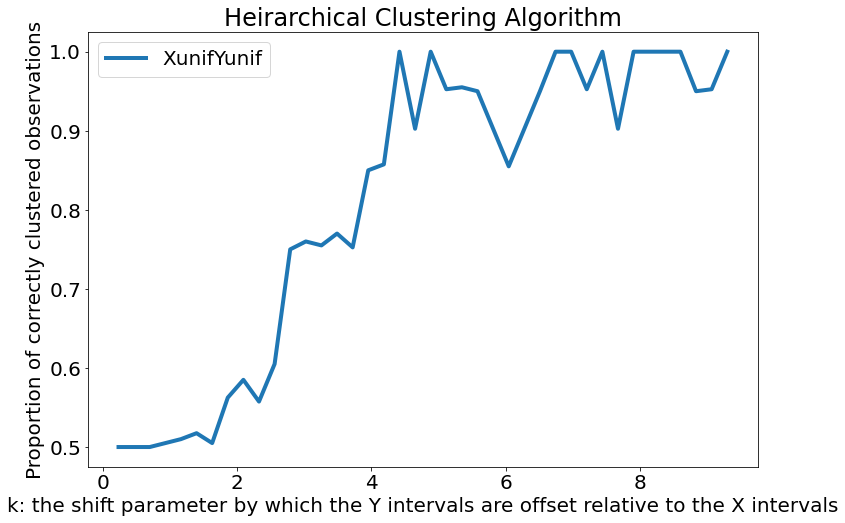

In [29]:
plt.plot(K, correct_k_XunifYunif, label="XunifYunif", linewidth=4)
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

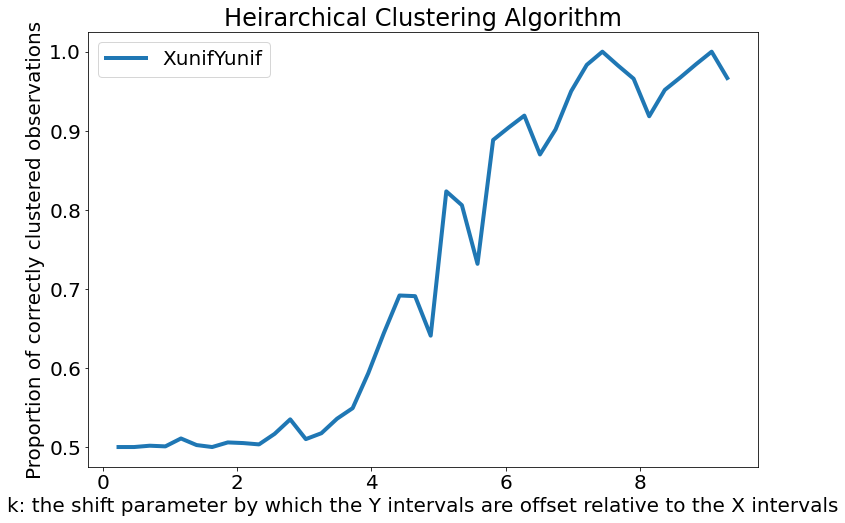

In [459]:
plt.plot(K, correct_k_XunifYunif, label="XunifYunif", linewidth=4)
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

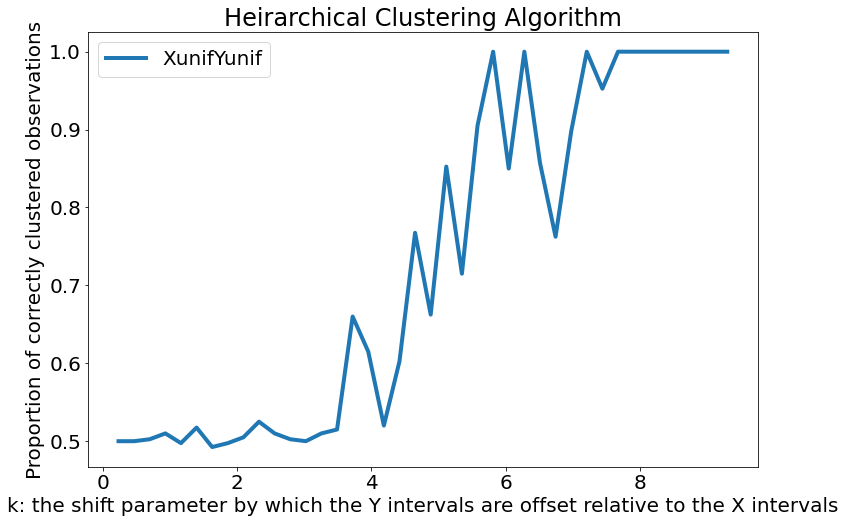

In [447]:
plt.plot(K, correct_k_XunifYunif, label="XunifYunif", linewidth=4)
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

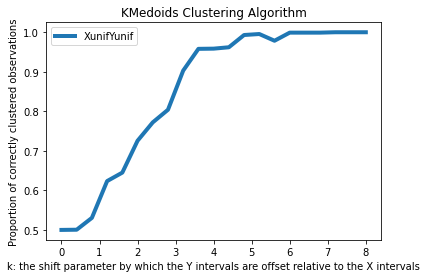

In [115]:
plt.plot(K, correct_k_XunifYunif, label="XunifYunif", linewidth=4)
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

In [4]:
# function to load data
def load_data(csig=1., rlsig=1.):
    # XunifYunif
    with open(f'../data/correct_csig{csig}_rlsig{rlsig}_XunifYunif.pickle','rb') as picklein:
        globals()['correct_XunifYunif'] = pickle.load(picklein)
    
    scenarios = ['XunifYsym', 'XsymYsym', 'XunifYskew', 'XsymYskew', 'XskewYskew']
    methods = [1,2]
    for scen in scenarios:
        for meth in methods:
            with open(f'../data/correct_csig{csig}_rlsig{rlsig}_{scen}_{meth}.pickle','rb') as picklein:
                globals()[f'correct_{scen}{meth}'] = pickle.load(picklein)

    return np.linspace(0.0465,0.93,20) if csig==0.1 else np.linspace(0.155,4.65,30) if csig==0.5 else np.linspace(0.2325,9.3,40)

In [5]:
# %matplotlib widget

def plot_data(K):
    plt.plot(K, correct_XunifYunif, label="XunifYunif", linewidth=4)

    scenarios = ['XunifYsym', 'XsymYsym', 'XunifYskew', 'XsymYskew', 'XskewYskew'] #  
    methods = [1,2]
    for scen in scenarios:
        for meth in methods:
            if meth==1:
                plt.plot(K, globals()[f'correct_{scen}{meth}'], label=f'{scen}{meth}', linewidth=4)
            else:
                plt.plot(K, globals()[f'correct_{scen}{meth}'], label=f'{scen}{meth}', linewidth=4, linestyle='--')
    
    plt.legend()
    plt.title("Heirarchical Clustering Algorithm")
    plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
    plt.ylabel("Proportion of correctly clustered observations")
    plt.show()

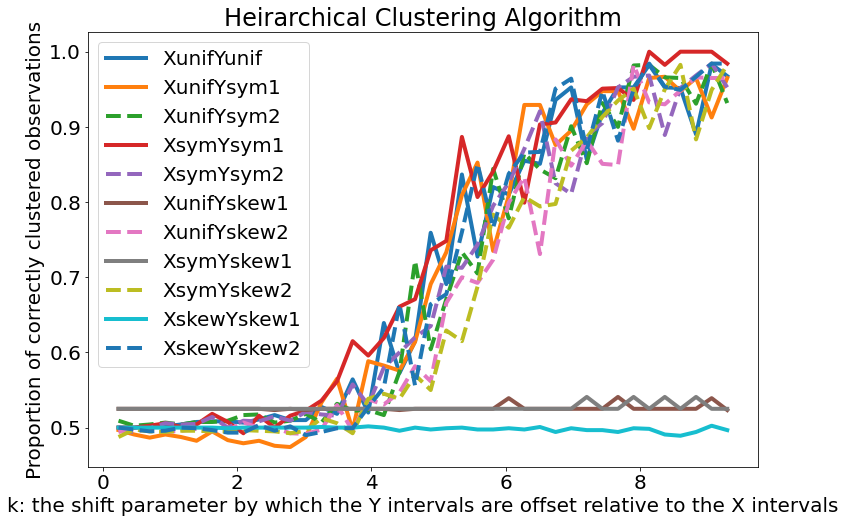

In [6]:
K = load_data()
plot_data(K)

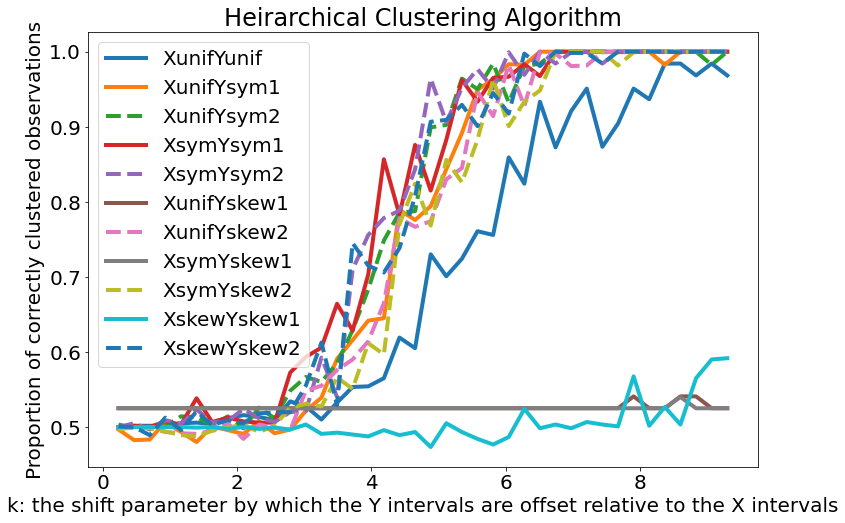

In [7]:
K = load_data(csig=1., rlsig=0.5)
plot_data(K)

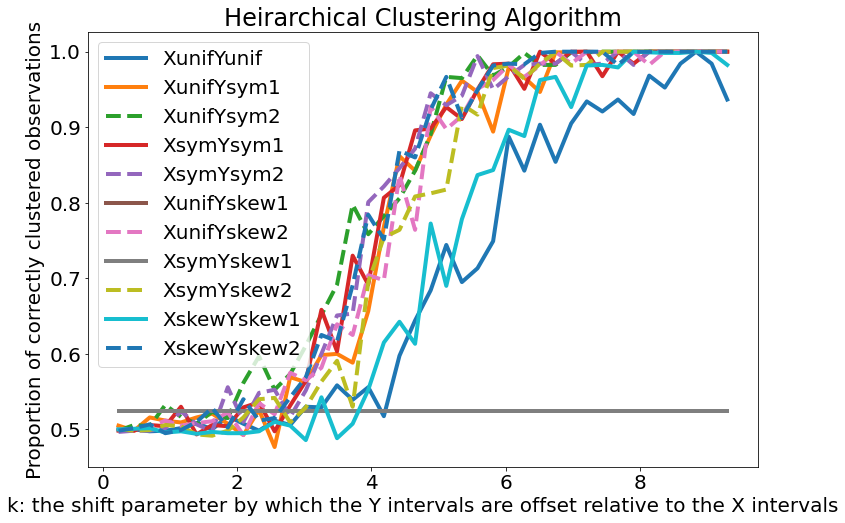

In [8]:
K = load_data(csig=1., rlsig=0.1)
plot_data(K)

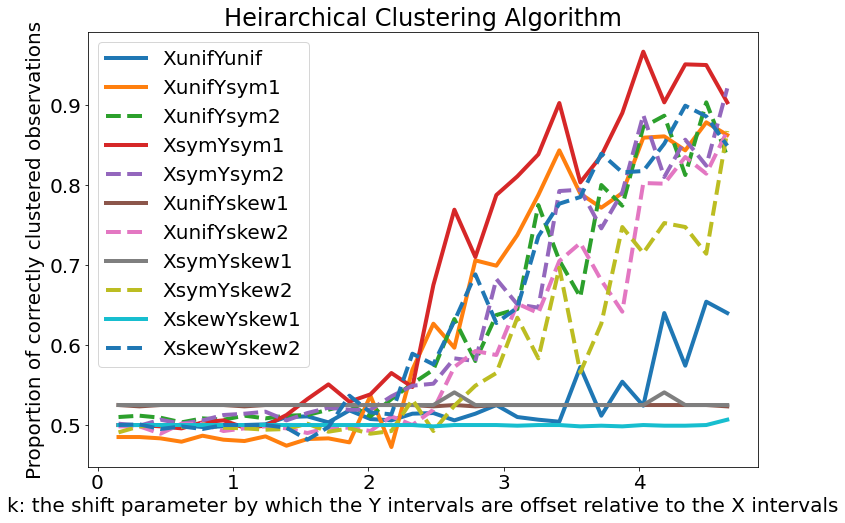

In [9]:
K = load_data(csig=.5, rlsig=1.)
plot_data(K)

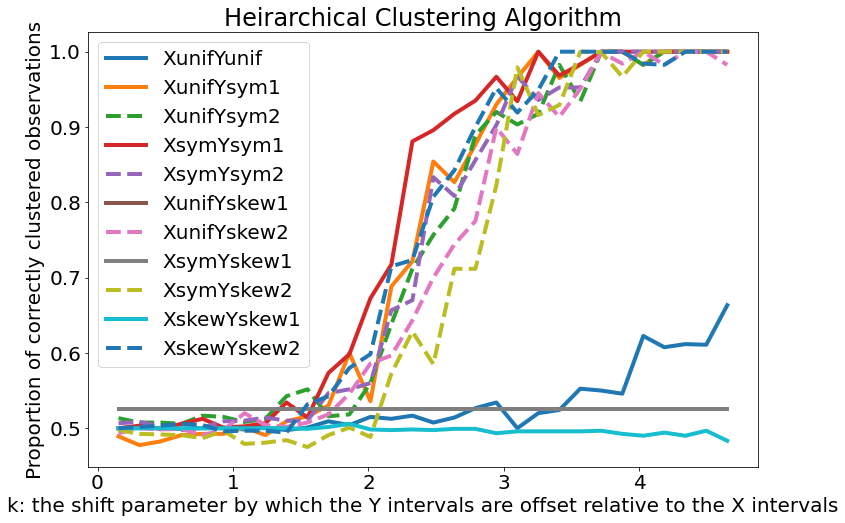

In [10]:
K = load_data(csig=.5, rlsig=0.5)
plot_data(K)

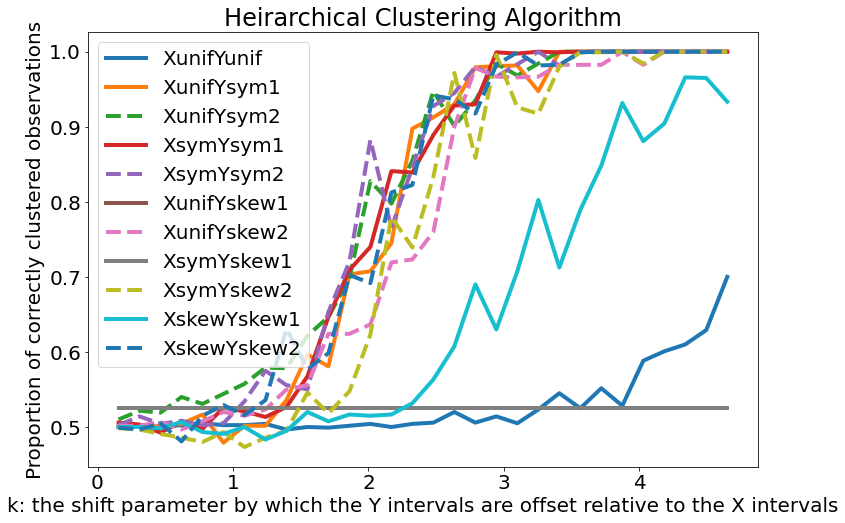

In [11]:
K = load_data(csig=.5, rlsig=0.1)
plot_data(K)

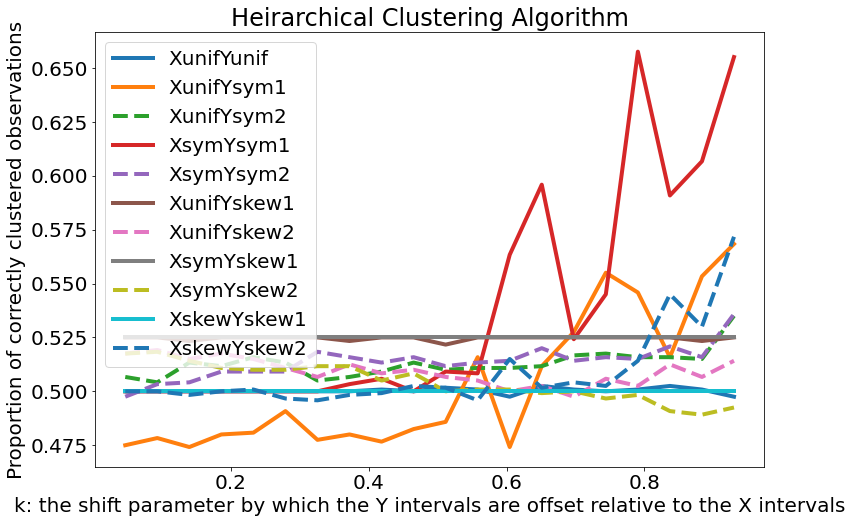

In [12]:
K = load_data(csig=.1, rlsig=1.)
plot_data(K)

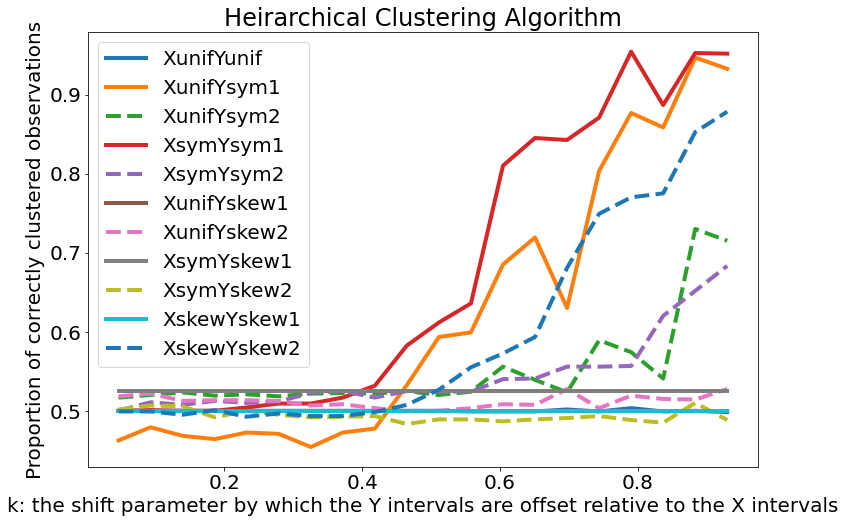

In [13]:
K = load_data(csig=.1, rlsig=0.5)
plot_data(K)

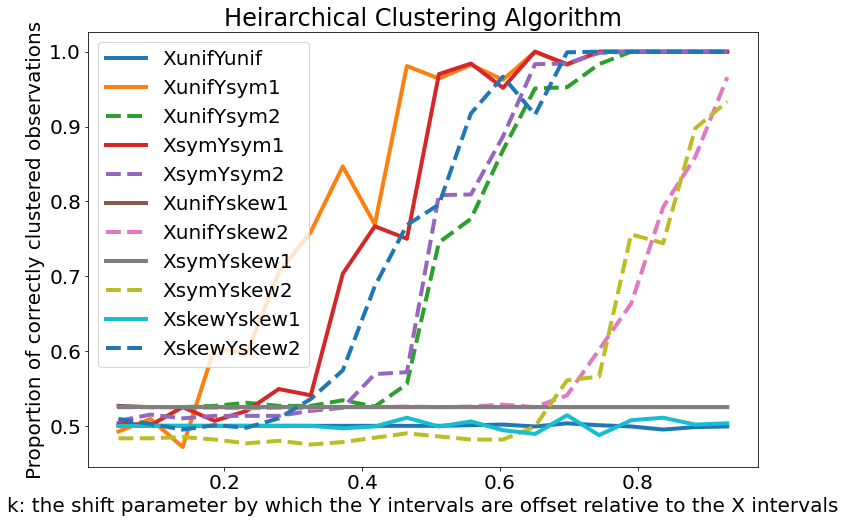

In [14]:
K = load_data(csig=.1, rlsig=0.1)
plot_data(K)

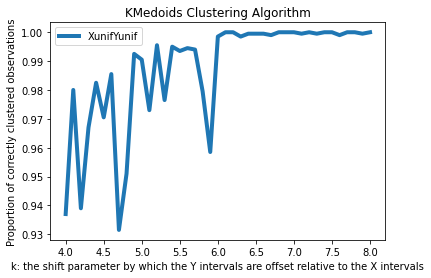

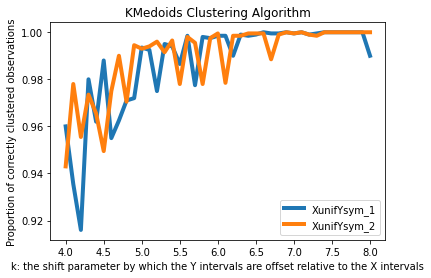

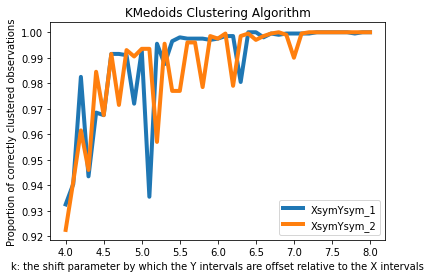

In [109]:
plt.plot(K, correct_k_XunifYunif, label="XunifYunif", linewidth=4)
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

plt.plot(K, correct_k_XunifYsym_1, label="XunifYsym_1", linewidth=4)
plt.plot(K, correct_k_XunifYsym_2, label="XunifYsym_2", linewidth=4)
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

plt.plot(K, correct_k_XsymYsym_1, label="XsymYsym_1", linewidth=4)
plt.plot(K, correct_k_XsymYsym_2, label="XsymYsym_2", linewidth=4)
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")
plt.show()

# scenarios = ['XunifYskew', 'XsymYskew', 'XskewYskew'] #  
# methods = [1,2]
# parts = [1,2]
# for s in scenarios:
#     for m in methods:
#         for p in parts:
#             with open(f'../data/correct_{s}_{m}_{p}.pickle','rb') as picklein:
#                 locals()[f'correct_k_{s}_{m}_{p}'] = pickle.load(picklein)
#         locals()[f'correct_k_{s}_{m}'] = locals()[f'correct_k_{s}_{m}_{1}'] + locals()[f'correct_k_{s}_{m}_{2}']
#         plt.plot(Kdict[s+str(m)], locals()[f'correct_k_{s}_{m}'], label=f'{s}_{m}', linewidth=4)
#     plt.legend()
#     plt.title("Heirarchical Clustering Algorithm")
#     plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
#     plt.ylabel("Proportion of correctly clustered observations")
#     plt.show()

In [104]:
correct = correct_k_XsymYskew_1
correct = np.array(correct)
np.all(correct == 1.0)

True

In [106]:
# function to find the k value where the correctly proportioned clusters jumps from 0.5 to 1.0
def ktransition(correct, K):
    correct = np.array(correct)
    first = K[np.diff(correct > 0.51).tolist()+[False]] 
    last = K[[False]+np.diff(correct < 1.).tolist()] 
    rv = np.mean([first, last])
    if np.all(correct == 1.0):
        return 0.0
    else:
        if np.isnan(rv):
            return -1.0
        else:
            return rv

In [108]:
ktransition(correct_k_XskewYskew_1, Kdict['XskewYskew1'])

-1.0

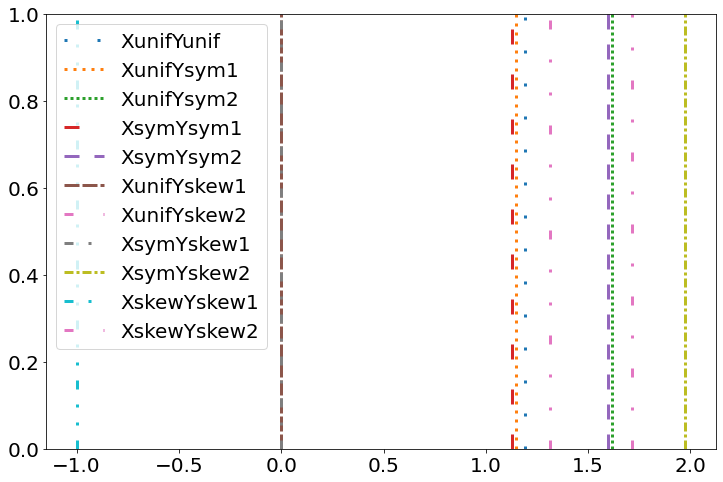

In [137]:
correct = [correct_k_XunifYunif, correct_k_XunifYsym_1, correct_k_XunifYsym_2, correct_k_XsymYsym_1, correct_k_XsymYsym_2, 
           correct_k_XunifYskew_1, correct_k_XunifYskew_2, correct_k_XsymYskew_1, correct_k_XsymYskew_2, correct_k_XskewYskew_1, 
           correct_k_XskewYskew_2]
K = [Kdict['XunifYunif'], Kdict['XunifYsym1'], Kdict['XunifYsym2'], Kdict['XsymYsym1'], Kdict['XsymYsym2'], 
     Kdict['XunifYskew1'], Kdict['XunifYskew2'],Kdict['XsymYskew1'], Kdict['XsymYskew2'], Kdict['XskewYskew1'], Kdict['XskewYskew2']]
labels = ['XunifYunif', 'XunifYsym1', 'XunifYsym2','XsymYsym1','XsymYsym2','XunifYskew1','XunifYskew2','XsymYskew1','XsymYskew2','XskewYskew1'
         ,'XskewYskew2']
vals = [ktransition(c, K) for c,K in zip(correct, K)]
linestyles = [
    (0, (1, 10)),
    (0, (1, 2)),
    (0, (1, 1)),

    (0, (5, 10)),
    (0, (5, 5)),
    (0, (5, 1)),

    (0, (3, 10, 1, 10)),
    (0, (3, 5, 1, 5)),
    (0, (3, 1, 1, 1)),

    (0, (3, 5, 1, 5, 1, 5)),
    (0, (3, 10, 1, 10, 1, 10))] 
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:pink', 'k']
for i, (v,l) in enumerate(zip(vals,labels)):
    plt.axvline(x=v, label=l, linestyle=linestyles[i], c=colours[i],linewidth=3)
plt.legend()

Text(0, 0.5, 'Proportion of correctly clustered observations')

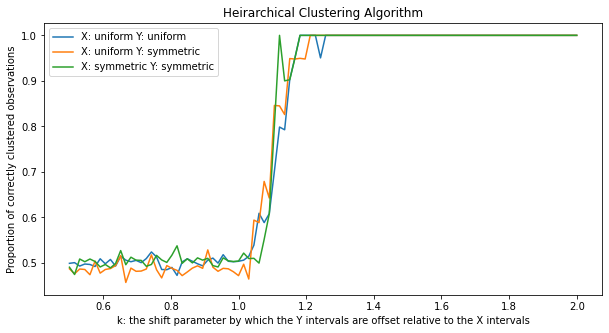

In [148]:
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")

Text(0, 0.5, 'Proportion of correctly clustered observations')

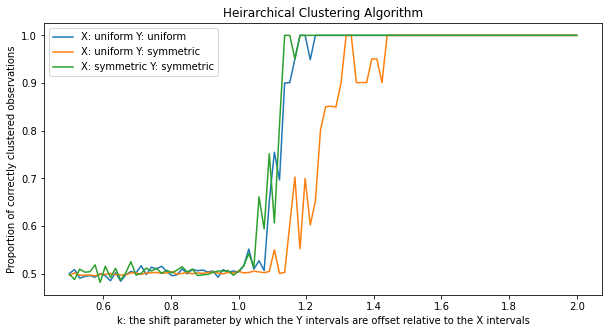

In [231]:
# Old clustering plot (based on erroneous distance calculation)
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("Heirarchical Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")

## KMedoids Clustering

In [149]:
K = np.linspace(0.5, 2, 100, endpoint=True)
correct_k_XunifYunif = clustering_sim(K, scenario="XunifYunif", algorithm="KMedoids")
correct_k_XunifYsym = clustering_sim(K, scenario="XunifYsym", algorithm="KMedoids")
correct_k_XsymYsym = clustering_sim(K, scenario="XsymYsym", algorithm="KMedoids")

Text(0, 0.5, 'Proportion of correctly clustered observations')

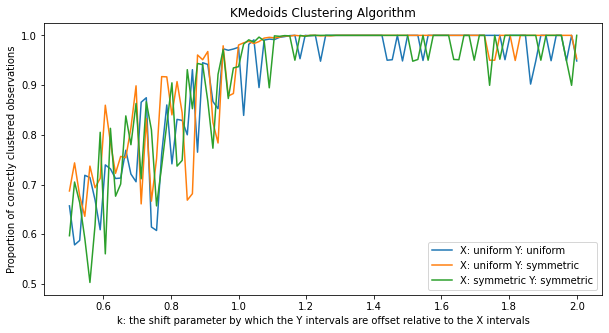

In [150]:
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")

Text(0, 0.5, 'Proportion of correctly clustered observations')

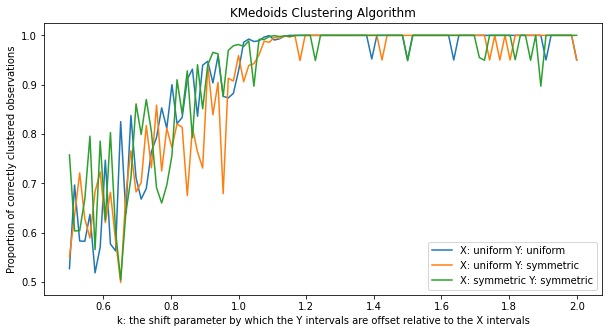

In [229]:
# Old plot based on erroneous distance calculations
plt.plot(K, correct_k_XunifYunif, label="X: uniform Y: uniform")
plt.plot(K, correct_k_XunifYsym, label="X: uniform Y: symmetric")
plt.plot(K, correct_k_XsymYsym, label="X: symmetric Y: symmetric")
plt.legend()
plt.title("KMedoids Clustering Algorithm")
plt.xlabel("k: the shift parameter by which the Y intervals are offset relative to the X intervals")
plt.ylabel("Proportion of correctly clustered observations")